# Feed Forward Neural Network

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

from tqdm.notebook import tqdm

#### Generate data

In [2]:
def generate_data(r_list, n, sigma):
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)
    x1_noise = np.random.normal(loc=0.0, scale=sigma, size=n)
    x2_noise = np.random.normal(loc=0.0, scale=sigma, size=n)
    
    data_list = []
    for r in r_list:
        x1 = r*np.cos(angles) + x1_noise
        x2 = r*np.sin(angles) + x2_noise

        x1 = np.expand_dims((np.array(x1)), axis = 1)
        x2 = np.expand_dims((np.array(x2)), axis = 1)
        
        x = np.concatenate((x1, x2), axis = 1)
        
        data_list.append(x)
        
    # Generate center blob
    data_list.append(np.random.normal(0, 0.5, (n, 2)))
    # Concatenate all data together 
    X = np.concatenate((data_list[0], data_list[1], data_list[2]), axis = 0)

    y = []
    for i in range(len(r_list)+1):
        y.extend([i] * (n))

    return X, np.array(y)


def plot_data(X, y):
    with plt.style.context('seaborn-darkgrid'):
        fig, ax = plt.subplots(figsize=(12, 10))
        plt.scatter(x=X[y==0][:, 0], y=X[y==0][:, 1], color='r', edgecolor='w', s=30, linewidth=1, label='y = 0')
        plt.scatter(x=X[y==1][:, 0], y=X[y==1][:, 1], color='g', edgecolor='w', s=30, linewidth=1, label='y = 1')
        plt.scatter(x=X[y==2][:, 0], y=X[y==2][:, 1], color='b', edgecolor='w', s=30, linewidth=1, label='y = 2')

        plt.legend()

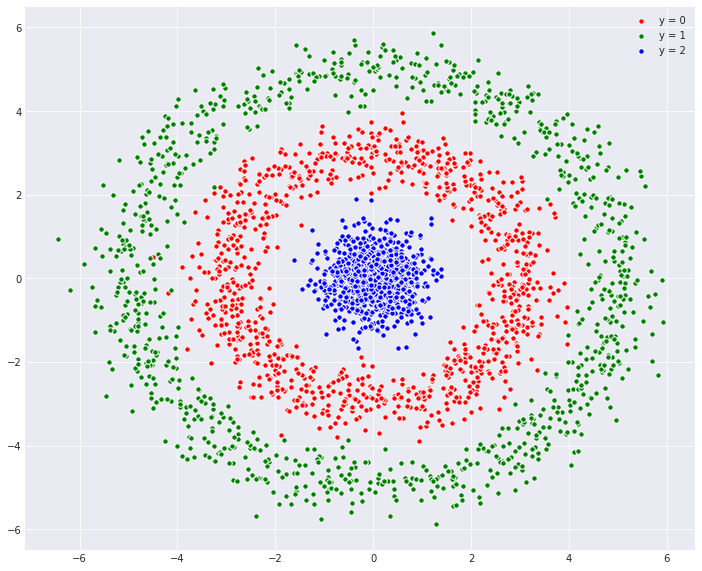

In [3]:
# Number of points per class
n = 1000

# Radius of circles
r_list = [3, 5]

# Sigma of circles
sigma = 0.4

X, y = generate_data(r_list, n, sigma=sigma)
plot_data(X, y)

#### Create datasets

In [4]:
def shuffle_data(X, y, seed):
    if seed:
        np.random.seed(seed)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return np.array(X)[idx], np.array(y)[idx]


def split_data(X, y, split=0.15):
    data = list(zip(X, y))
    split = len(data) - int(len(data) // (1 / split))
    
    training_data = data[:split]
    val_data = data[split:]
    
    train_X, train_y = zip(*training_data)
    val_X, val_y = zip(*val_data)
    
    return np.array(train_X), np.array(train_y), np.array(val_X), np.array(val_y)


X, y = shuffle_data(X, y, seed=None)
train_X, train_y, val_X, val_y = split_data(X, y)

print(f'Training set: Label 0: {np.count_nonzero(train_y == 0)}',
      f'Label 1: {np.count_nonzero(train_y == 1)}',
      f'Label 2: {np.count_nonzero(train_y == 2)}')
print(f'Validation set: Label 0: {np.count_nonzero(val_y == 0)}',
      f'Label 1: {np.count_nonzero(val_y == 1)}',
      f'Label 2: {np.count_nonzero(val_y == 2)}')

Training set: Label 0: 855 Label 1: 853 Label 2: 843
Validation set: Label 0: 145 Label 1: 147 Label 2: 157


### Model

All outputs have to pass through a non-linear function for the model to be able to learn any complex data. Without them, the neural network is just one big linear classifier.

ReLU is one of the more commonly used activation functions. Outputs that pass through it are zero-gated. Negative inputs become zero.

<br>

$$
f(x) = \max(0, x)
$$

![ReLU](../img/relu.png)

<br>

ReLU is prone to vanishing gradients when the number of layers in the network gets larger as larger. Gradients for outputs less than zero are equal to zero, and hence neurons upstream do not get updated with back-propagation. Other variants of ReLU have been suggested like Leaky ReLU, PReLU, and swishes.

<br>

Softmax activation is used at the last layer to intepret the scores as estimated class probabilities. Take the exponential of the logit score and divide it by the sum of exponentials of the other scores.

<br>

$$
f(x) = \frac{e^{f_{y_i}}}{\sum_j e^{f_j} }
$$

<br>

With softmax, the exponentials can get very large, resulting in numerical instability. Thus exponential values are sometimes shifted by the largest value such that the largest value is now at zero. This will not be a problem in the simple example in this notebook though.

In [5]:
# ReLU non-linear activation
def relu(x):
    return np.maximum(0, x)

# Stable softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return probs

In [6]:
class NN:
    def __init__(self,
             layer_config=[2, 6, 6, 3],
             learning_rate=0.001,
             scheduler=None):

        self.learning_rate = learning_rate
        self.scheduler = scheduler
        self.layer_config = layer_config
        self.weights = []
        self.biases = []
        
        # Kaiming initialization of weights and biases
        for i in range(len(self.layer_config)-1):
            self.weights.append(np.random.normal(size=(self.layer_config[i], self.layer_config[i+1])) 
                                * math.sqrt(2./self.layer_config[i]))
            self.biases.append(np.zeros((1, self.layer_config[i+1])))
            
            
    def fit(self, train_X, train_y, val_X, val_y, num_epoch, batch_size):
        since = time.time()
        
        self.batch_size = batch_size
        
        training_data = list(zip(train_X, train_y))
        val_data = list(zip(val_X, val_y))
        
        # To store losses, accuracies over batches
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        # To store best weights and biases, based on lowest val loss
        best_model_wts = copy.deepcopy(self.weights)
        best_model_bias = copy.deepcopy(self.biases)
        best_loss = 0.0

        for i in range(1, num_epoch+1):
            
            # Step learning rate scheduler
            # If current epoch - 1 == num_epoch * first element in scheduler,
            # Reduce LR by factor of 0.1
            if self.scheduler and i-1 == int(num_epoch * self.scheduler[0]):
                self.learning_rate = self.learning_rate * 0.1
                del self.scheduler[0]

            print('='*80)
            print(f'Epoch {i}/{num_epoch}, Learning Rate = {self.learning_rate:.1}')
            print('='*80)
            
            # Shuffle training data before splitting into mini-batches
            np.random.shuffle(training_data)
            
            # Split data into mini-batches
            mini_batches = [
                training_data[k:k + self.batch_size] for k in
                range(0, len(training_data), self.batch_size)]
            
            # For epoch metrics
            train_running_loss = 0.0
            train_running_corrects = 0
            val_running_loss = 0.0
            val_running_corrects = 0

            for j in tqdm(range(len(mini_batches))):
                # Unpack mini-batch
                mini_batch_X, mini_batch_y = zip(*mini_batches[j])
                mini_batch_X = np.array(mini_batch_X)
                mini_batch_y = np.array(mini_batch_y)
                
                # Obtain training and validation accuracies before tuning weights
                train_acc = self.validate(train_X, train_y)
                val_acc = self.validate(val_X, val_y)
        
                # Forward Pass
                # Forward pass training data second so that
                # self.activations are based on training data
                val_probs, val_loss = self.forward_pass(val_X, val_y, train=False)
                train_probs, train_loss = self.forward_pass(mini_batch_X, mini_batch_y)
                
                # Backward Pass and tune weights
                self.backward_pass(train_probs, mini_batch_X, mini_batch_y)
                
                # Store accuracies and losses for plotting
                self.train_losses.append(train_loss), self.val_losses.append(val_loss)
                self.train_accuracies.append(train_acc), self.val_accuracies.append(val_acc)
                                
                # Increment epoch metrics
                train_running_loss += train_loss
                train_running_corrects += train_acc
                val_running_loss += val_loss
                val_running_corrects += val_acc
                
            print(
                f'Epoch Training Accuracy: {train_running_corrects/len(mini_batches):.4f} ' 
                f'Loss: {train_running_loss/len(mini_batches):.4f}'
            )
            print(
                f'Epoch Validation Accuracy: {val_running_corrects/len(mini_batches):.4f} '
                f'Loss: {val_running_loss/len(mini_batches):.4f}\n'
            )
            
            # If first epoch, store current val loss as best loss
            # else, if current val loss is better than best loss, 
            # best loss is current loss.
            # Store current weights and biases as best ones
            if i == 1:
                best_loss = val_running_loss/len(mini_batches)
            elif val_running_loss/len(mini_batches) < best_loss:
                best_loss = val_running_loss/len(mini_batches)
                best_model_wts = copy.deepcopy(self.weights)
                best_model_bias = copy.deepcopy(self.biases)
                
        
        # Load best model weights
        self.weights = best_model_wts
        self.biases = best_model_bias
                       
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Validation Loss {:.4f}'.format(best_loss))
        

    def forward_pass(self, X, y, train=True):
        # Activations cache to store activations after each layer           
        self.activations = []
        
        for i in range(len(self.weights)):
            # If last layer, softmax on outputs
            if i == len(self.weights)-1:
                scores = np.dot(X, self.weights[-1]) + self.biases[-1]
                # Softmax
                probs = softmax(scores)
                self.activations.append(probs)
                
                # If we just want to get activations and not losses
                if y is not None:
                    correct_logprobs = -np.log(probs[range(len(X)),y])
                    loss = np.sum(correct_logprobs)/len(X)
                    return probs, loss 
                
            # If not at last layer, ReLU on outputs    
            else:
                hidden_layer = relu(np.dot(X, self.weights[i]) + self.biases[i])
                self.activations.append(hidden_layer)
                X = hidden_layer
                
    def backward_pass(self, probs, X, y):    
        dscores = probs
        # Backprop softmax to get gradient of last layer
        dscores[range(len(X)),y] -= 1     
        dscores /= len(X)
        
        # Calculate gradients from back to front of network
        # Start from last layer - 1
        for i in range(len(self.activations)-1, -1, -1):
            # If not at first layer
            if i > 0:
                dw = np.dot(self.activations[i-1].T, dscores)
                db = np.sum(dscores, axis=0, keepdims=True)
                dhidden = np.dot(dscores, self.weights[i].T)
                
                # Backprop ReLU
                dhidden[self.activations[i-1] <= 0] = 0
                dscores = dhidden
            
            else:
                dw = np.dot(X.T, dscores)
                db = np.sum(dscores, axis=0, keepdims=True)
            
            # Update weights and biases at each layer
            self.weights[i] = self.weights[i] - self.learning_rate * dw
            self.biases[i] = self.biases[i] - self.learning_rate * db
            
            
    def validate(self, X, y):
        self.forward_pass(X, y=None)
        
        # y_preds store the activations of the last layer in the network
        # Last layer corresponds to the scores of each class
        y_pred = self.activations[-1]
        correct = 0
        
        # Iterate through X and compare predicted and ground truths. 
        for i in range(len(X)):
            # If class of predicted highest score is same as target, increment
            correct += (np.argmax(y_pred[i]) == y[i])
        
        # Divide total with number of data to get accuracy
        return correct / len(X)

Courtesy of NN SVG(https://alexlenail.me/NN-SVG/), we can visualize the model configuration [2, 20, 20, 3] below:
![Three Layer Net](../img/nn.jpg)

The first layer is the input layer. It has 2 nodes/units/neurons because each datapoint is represented as 2 features (shown in the plot above in feature space). The last layer has 3 units corresponding to the 3 classes a datapoint can be in. Bias units are not included in the picture above.

In [7]:
#Number of Epochs
num_epoch = 20

#Initial Learning Rate
learning_rate = 0.1

# Lr Scheduler
scheduler = [0.5, 0.75]

# Desired batch size
BS = 32

# Layer configuration, including input and output layers
# Values correspond to units in each layer
config = [2, 20, 20, 3]

neural_net = NN(learning_rate=learning_rate, scheduler=scheduler, layer_config=config)
neural_net.fit(train_X, train_y, val_X, val_y, num_epoch=num_epoch, batch_size=BS)

Epoch 1/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.6663 Loss: 0.8637
Epoch Validation Accuracy: 0.6775 Loss: 0.8512

Epoch 2/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.8588 Loss: 0.4005
Epoch Validation Accuracy: 0.8672 Loss: 0.3894

Epoch 3/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9116 Loss: 0.2821
Epoch Validation Accuracy: 0.9128 Loss: 0.2730

Epoch 4/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9376 Loss: 0.2066
Epoch Validation Accuracy: 0.9381 Loss: 0.2079

Epoch 5/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9540 Loss: 0.1585
Epoch Validation Accuracy: 0.9526 Loss: 0.1574

Epoch 6/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9675 Loss: 0.1217
Epoch Validation Accuracy: 0.9651 Loss: 0.1218

Epoch 7/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9765 Loss: 0.0887
Epoch Validation Accuracy: 0.9734 Loss: 0.0929

Epoch 8/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9776 Loss: 0.0850
Epoch Validation Accuracy: 0.9746 Loss: 0.0864

Epoch 9/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9855 Loss: 0.0554
Epoch Validation Accuracy: 0.9807 Loss: 0.0646

Epoch 10/20, Learning Rate = 0.1


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9791 Loss: 0.0727
Epoch Validation Accuracy: 0.9753 Loss: 0.0788

Epoch 11/20, Learning Rate = 0.01


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9899 Loss: 0.0408
Epoch Validation Accuracy: 0.9871 Loss: 0.0488

Epoch 12/20, Learning Rate = 0.01


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9953 Loss: 0.0337
Epoch Validation Accuracy: 0.9915 Loss: 0.0380

Epoch 13/20, Learning Rate = 0.01


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9952 Loss: 0.0334
Epoch Validation Accuracy: 0.9912 Loss: 0.0374

Epoch 14/20, Learning Rate = 0.01


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9952 Loss: 0.0326
Epoch Validation Accuracy: 0.9916 Loss: 0.0369

Epoch 15/20, Learning Rate = 0.01


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9953 Loss: 0.0326
Epoch Validation Accuracy: 0.9909 Loss: 0.0365

Epoch 16/20, Learning Rate = 0.001


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9957 Loss: 0.0314
Epoch Validation Accuracy: 0.9911 Loss: 0.0366

Epoch 17/20, Learning Rate = 0.001


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9954 Loss: 0.0313
Epoch Validation Accuracy: 0.9911 Loss: 0.0363

Epoch 18/20, Learning Rate = 0.001


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9954 Loss: 0.0313
Epoch Validation Accuracy: 0.9911 Loss: 0.0361

Epoch 19/20, Learning Rate = 0.001


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9953 Loss: 0.0313
Epoch Validation Accuracy: 0.9911 Loss: 0.0360

Epoch 20/20, Learning Rate = 0.001


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch Training Accuracy: 0.9953 Loss: 0.0313
Epoch Validation Accuracy: 0.9911 Loss: 0.0359

Training completed in 0m 18s
Best Validation Loss 0.0359


#### Plot History

Plot accuracy and loss history during training. Plots are abit jittery and not smooth as stochastic gradient descent was used, and the history was recorded after each mini-batch. The mini-batch size can give rise to smoother or less smoother curves. Typically a larger batch size will result in smoother curves as there is less variation between mini-batches.

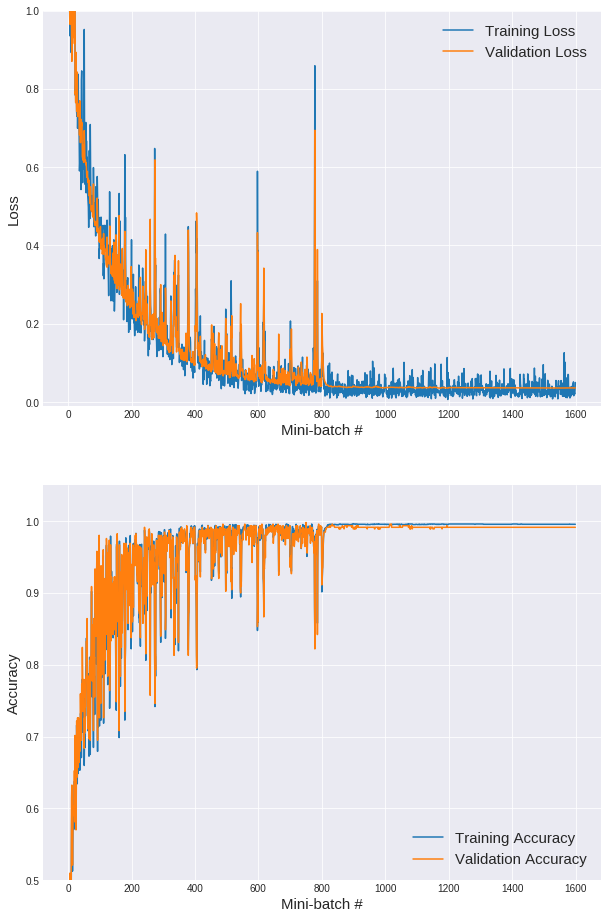

In [8]:
with plt.style.context('seaborn-darkgrid'):
    
    fig = plt.figure(figsize=(10,16))
    
    # Summarize history for loss
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(neural_net.train_losses)), neural_net.train_losses, label='Training Loss')
    plt.plot(np.arange(len(neural_net.val_losses)), neural_net.val_losses, label='Validation Loss')
    plt.ylim(-0.01, 1)
    plt.xlabel('Mini-batch #', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(fontsize=15)
    
    # Summarize history for accuracy
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(neural_net.train_accuracies)), neural_net.train_accuracies, label='Training Accuracy')
    plt.plot(np.arange(len(neural_net.val_accuracies)), neural_net.val_accuracies, label='Validation Accuracy')
    plt.xlabel('Mini-batch #', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(0.5, 1.05)
    plt.legend(fontsize=15)
    plt.show()

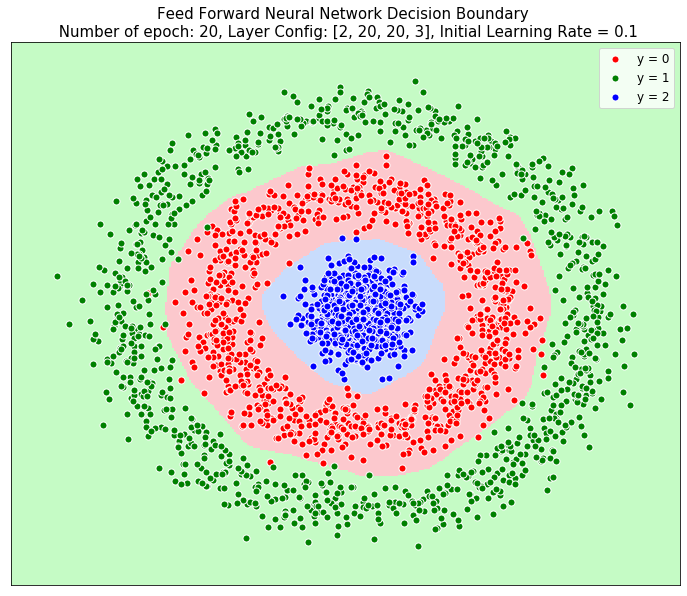

In [9]:
from matplotlib.colors import ListedColormap

# Step size in the mesh
h = .04

# Plot the decision boundary. 
# For that, we will assign a color to each point in the mesh [x_min, x_max], [y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
X0, X1 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
xy = np.vstack([X0.ravel(), X1.ravel()]).T

# Get predictions for each point in mesh. Stored as neural_net.activations[-1]
neural_net.forward_pass(xy, y=None)

Z = [np.argmax(neural_net.activations[-1][i]) for i in range(len(xy))]
Z = np.array(Z)
Z = Z.reshape(X0.shape)

# Create color map
cmap_light = ListedColormap(['#FCC8CD', '#C5FBC5', '#C8DCFC'])

fig = plt.figure(figsize=(12,10))
plt.pcolormesh(X0, X1, Z, cmap=cmap_light)
plt.scatter(x=X[y==0][:, 0], y=X[y==0][:, 1], color='r', edgecolor='w', linewidth=1, s=50, label='y = 0')
plt.scatter(x=X[y==1][:, 0], y=X[y==1][:, 1], color='g', edgecolor='w', linewidth=1, s=50, label='y = 1')
plt.scatter(x=X[y==2][:, 0], y=X[y==2][:, 1], color='b', edgecolor='w', linewidth=1, s=50, label='y = 2')
plt.xticks([])
plt.yticks([])
plt.title(f'Feed Forward Neural Network Decision Boundary \n Number of epoch: {num_epoch}, Layer Config: {config}, Initial Learning Rate = {learning_rate}',fontsize=15)
plt.legend(fontsize=12)
plt.show()

## References
[1] CS231n: Convolutional Neural Networks for Visual Recognition, 2016. Fei-Fei Li, Andrej Karpathy, Justin Johnson. Stanford University. http://cs231n.stanford.edu/2016/.